In [4]:
import pandas as pd

df = pd.read_csv('data/processed/rome_clean.csv')
df.head()

,idS,tsO,tsD,price,tt,dis,vel,lonO,latO,lonD,latD,duration_calc
0,A0H4,2021-02-03 18:10:03,2021-02-03 18:17:44,2.1525,461,1715.336751,13.395254,12.466222,41.867388,12.470660,41.853908,461.0
1,A0H4,2021-02-13 18:21:13,2021-02-13 18:25:33,1.6500,260,1234.472044,17.092690,12.471143,41.923692,12.467502,41.934306,260.0
2,A0H4,2021-02-14 13:39:54,2021-02-14 13:48:03,2.2225,489,2221.481536,16.354465,12.467524,41.934342,12.486330,41.928270,489.0
3,A0H4,2021-02-14 14:37:53,2021-02-14 14:57:53,4.0000,1200,4562.843566,13.688531,12.486275,41.928301,12.457922,41.904302,1200.0
4,A0H4,2021-02-15 13:31:24,2021-02-15 13:34:45,1.5025,201,550.154792,9.853519,12.457876,41.904303,12.460773,41.907606,201.0


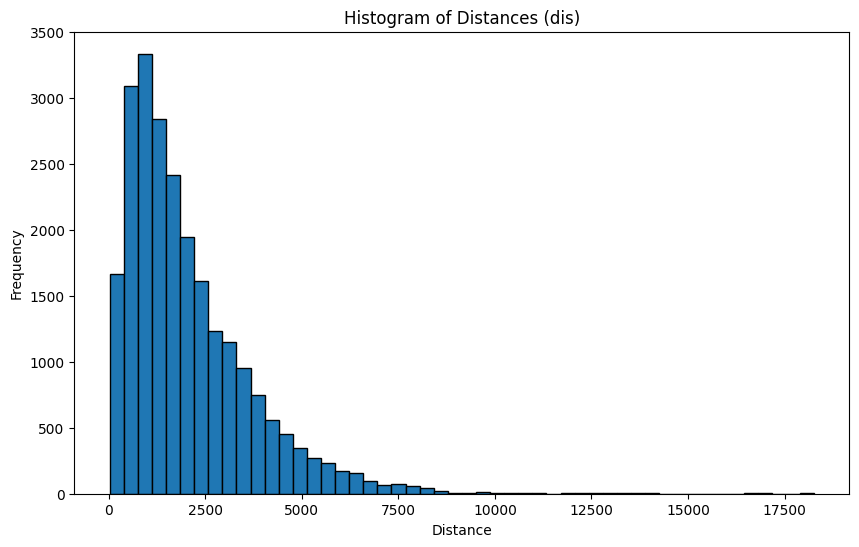

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df['dis'].hist(bins=50, edgecolor='black')
plt.title('Histogram of Distances (dis)')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [6]:
coords_df = df[['lonO', 'latO', 'lonD', 'latD', 'idS', 'dis']]
def categorize_distance(dis):
    if dis < 2500:
        return 'corto'
    elif dis < 5000:
        return 'medio'
    else:
        return 'largo'
    
def wait(dis):
    if dis == 'corto':
        return 300
    elif dis == 'medio':
        return 420
    else:
        return 600

coords_df['type'] = coords_df['dis'].apply(categorize_distance)
coords_df['wait'] = coords_df['type'].apply(wait)
coords_df.head()

C:\Users\Mario\AppData\Local\Temp\ipykernel_24384\4158921111.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords_df['type'] = coords_df['dis'].apply(categorize_distance)
C:\Users\Mario\AppData\Local\Temp\ipykernel_24384\4158921111.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords_df['wait'] = coords_df['type'].apply(wait)


,lonO,latO,lonD,latD,idS,dis,type,wait
0,12.466222,41.867388,12.470660,41.853908,A0H4,1715.336751,corto,300
1,12.471143,41.923692,12.467502,41.934306,A0H4,1234.472044,corto,300
2,12.467524,41.934342,12.486330,41.928270,A0H4,2221.481536,corto,300
3,12.486275,41.928301,12.457922,41.904302,A0H4,4562.843566,medio,420
4,12.457876,41.904303,12.460773,41.907606,A0H4,550.154792,corto,300


In [7]:
coords_origin_df = coords_df[['lonO', 'latO', 'idS', 'type', 'wait']]
coords_destination_df = coords_df[['lonD', 'latD', 'idS', 'type', 'wait']]

In [8]:
coords_origin_df.head()

,lonO,latO,idS,type,wait
0,12.466222,41.867388,A0H4,corto,300
1,12.471143,41.923692,A0H4,corto,300
2,12.467524,41.934342,A0H4,corto,300
3,12.486275,41.928301,A0H4,medio,420
4,12.457876,41.904303,A0H4,corto,300


In [9]:
coords_destination_df.head()

,lonD,latD,idS,type,wait
0,12.470660,41.853908,A0H4,corto,300
1,12.467502,41.934306,A0H4,corto,300
2,12.486330,41.928270,A0H4,corto,300
3,12.457922,41.904302,A0H4,medio,420
4,12.460773,41.907606,A0H4,corto,300


x Aplicamos HDBSCAN por separado sobre los puntos de origen y de destino (al final no utilizamos esta técnica porque no nos interesa tanto la densidad de los puntos si no la distancia a los centroides)

x Aplicamos Fuzzy C-Means que agrupa segun la distancia a los centroides con un grado de pertenencia (tarda mucho en ejecutar y queremos probar para encontrar el mejor k)

Aplicamos K-Means porque es más rápido y queremos encontrar el mejor valor de k

In [118]:
from sklearn.cluster import KMeans
from tqdm import tqdm

def clusterizar_coordenadas(df, coords_cols, k_values=[100,150,200,250,300,350,400], random_state=42):
    """
    Clusteriza un DataFrame usando KMeans para varios valores de k con barra de progreso.
    
    Args:
        df (pd.DataFrame): DataFrame con las coordenadas.
        coords_cols (list): Lista con los nombres de las columnas de coordenadas, e.g., ['lat','lon'].
        k_values (list): Lista de valores de k a probar.
        random_state (int): Semilla para reproducibilidad.
    
    Returns:
        pd.DataFrame: DataFrame con nuevas columnas cluster_k para cada valor de k.
    """
    for k in tqdm(k_values, desc="Clustering"):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        df[f'cluster_{k}'] = kmeans.fit_predict(df[coords_cols])
    return df

In [119]:
k_values = list(range(270, 281, 1))
coords_origin_df = clusterizar_coordenadas(coords_origin_df, coords_cols=['latO','lonO'], k_values=k_values)

Clustering:   0%|          | 0/11 [00:00<?, ?it/s]C:\Users\Mario\AppData\Local\Temp\ipykernel_13280\2526192268.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Clustering:   9%|▉         | 1/11 [00:00<00:07,  1.37it/s]C:\Users\Mario\AppData\Local\Temp\ipykernel_13280\2526192268.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Clustering: 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


In [120]:
coords_origin_df.head()

,lonO,latO,idS,type,wait,cluster_270,cluster_271,cluster_272,cluster_273,cluster_274,cluster_275,cluster_276,cluster_277,cluster_278,cluster_279,cluster_280
0,12.466222,41.867388,A0H4,corto,300,24,24,187,187,187,187,187,187,187,187,187
1,12.471143,41.923692,A0H4,corto,300,102,102,102,102,102,102,102,102,102,102,102
2,12.467524,41.934342,A0H4,corto,300,193,193,193,193,193,193,193,193,193,193,193
3,12.486275,41.928301,A0H4,medio,420,123,123,123,123,123,123,123,123,123,123,123
4,12.457876,41.904303,A0H4,corto,300,254,254,254,254,254,254,254,254,254,254,254


Ahora vamos a calcular el número de viajes que se 'descartarían' para cada valor de k. Esto depende de la distancia del viaje que se va a realizar.

In [121]:
import numpy as np

def haversine_dist(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia Haversine en metros entre dos puntos (lat, lon).
    """
    R = 6371000  # Radio de la Tierra en metros
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def viajes_fuera_de_radio(df, coords_cols=['latO','lonO'], k_values=[100,150,200,250,300,350,400], velocidad_kmh=5):
    resultados = {}
    
    for k in k_values:
        cluster_col = f'cluster_{k}'
        fuera = 0
        
        # Obtener centroides
        centroides = df.groupby(cluster_col)[coords_cols].mean()
        
        for idx, row in df.iterrows():
            centroide = centroides.loc[row[cluster_col]]
            distancia_m = haversine_dist(row[coords_cols[0]], row[coords_cols[1]],
                                        centroide[coords_cols[0]], centroide[coords_cols[1]])
            
            max_dist = (velocidad_kmh * 1000 / 3600) * row['wait']
            
            if distancia_m > max_dist:
                fuera += 1
        
        resultados[k] = fuera
    
    return resultados


In [122]:
coords_origin_results = viajes_fuera_de_radio(coords_origin_df, k_values=k_values)
coords_origin_results

{270: 58,
 271: 58,
 272: 49,
 273: 49,
 274: 45,
 275: 45,
 276: 45,
 277: 40,
 278: 40,
 279: 40,
 280: 34}

Vamos a hacer una gráfica para comparar el valor de silhouette score con los viajes descartados en función del valor de número de clústers

In [123]:
import plotly.graph_objects as go

def plot_silhouette_vs_viajes(k_values, silhouette_scores, viajes_fuera):
    """
    Grafica silhouette score y viajes fuera de radio en función de k.
    
    Args:
        k_values (list): Lista de valores de k.
        silhouette_scores (list): Lista de silhouette scores correspondientes a cada k.
        viajes_fuera (dict): Diccionario {k: número de viajes fuera de radio}.
    """
    # Convertir dict de viajes a lista en el mismo orden de k_values
    viajes = [viajes_fuera[k] for k in k_values]
    silhouette_scores = [silhouette_scores[k] for k in k_values]
    
    fig = go.Figure()
    
    # Línea de silhouette score
    fig.add_trace(go.Scatter(
        x=k_values,
        y=silhouette_scores,
        name='Silhouette Score',
        mode='lines+markers',
        yaxis='y1'
    ))
    
    # Línea de viajes fuera de radio
    fig.add_trace(go.Scatter(
        x=k_values,
        y=viajes,
        name='Viajes fuera de radio',
        mode='lines+markers',
        yaxis='y2'
    ))
    
    # Configurar ejes
    fig.update_layout(
        title='Silhouette Score vs Viajes fuera de radio',
        xaxis=dict(title='Número de clusters k'),
        yaxis=dict(title='Silhouette Score', side='left'),
        yaxis2=dict(title='Viajes fuera de radio', overlaying='y', side='right'),
        legend=dict(x=0.1, y=1.1, orientation='h')
    )
    
    fig.show()

In [124]:
from sklearn.metrics import silhouette_score

def calcular_silhouette(df, coords_cols=['latO','lonO'], k_values=[100,150,200,250,300,350,400]):
    """
    Calcula el silhouette score para cada clustering guardado en cluster_k.
    
    Args:
        df (pd.DataFrame): DataFrame con las coordenadas y las columnas cluster_k.
        coords_cols (list): Columnas de lat/lon.
        k_values (list): Valores de k.
    
    Returns:
        dict: {k: silhouette score}
    """
    scores = {}
    X = df[coords_cols].values
    
    for k in k_values:
        cluster_col = f'cluster_{k}'
        labels = df[cluster_col].values
        if len(set(labels)) > 1:  # Silhouette necesita al menos 2 clusters
            score = silhouette_score(X, labels)
        else:
            score = 0
        scores[k] = score
    return scores


In [125]:
sil_scores = calcular_silhouette(coords_origin_df, coords_cols=['latO','lonO'], k_values=k_values)

In [126]:
plot_silhouette_vs_viajes(k_values, sil_scores, coords_origin_results)


Después de este analisis sobre los viajes de origin, concluimos que el k de las estaciones debe ser 280 (SS=0.5101933, Viajes descartados=34)

In [128]:
coords_origin_df = coords_origin_df[['lonO', 'latO', 'idS', 'type', 'cluster_280']]
coords_origin_df.head()

,lonO,latO,idS,type,cluster_280
0,12.466222,41.867388,A0H4,corto,187
1,12.471143,41.923692,A0H4,corto,102
2,12.467524,41.934342,A0H4,corto,193
3,12.486275,41.928301,A0H4,medio,123
4,12.457876,41.904303,A0H4,corto,254


In [133]:
import folium
import webbrowser
import tempfile
import pandas as pd

cluster_col = 'cluster_280'
coords_cols = ['latO', 'lonO']

# Calcular centroides
centroides = coords_origin_df.groupby(cluster_col)[coords_cols].mean().reset_index()

# Crear mapa centrado en los puntos
mapa = folium.Map(location=[coords_origin_df['latO'].mean(), coords_origin_df['lonO'].mean()], zoom_start=13)

# Colores para clusters
colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue', 'cadetblue', 'darkgreen', 'pink']

# Añadir centroides
for i, row in centroides.iterrows():
    folium.Marker(
        location=[row['latO'], row['lonO']],
        popup=f"Cluster {row[cluster_col]}",
        icon=folium.Icon(color=colores[i % len(colores)], icon='star')
    ).add_to(mapa)

# Añadir puntos
for i, row in coords_origin_df.iterrows():
    folium.CircleMarker(
        location=[row['latO'], row['lonO']],
        radius=3,
        color=colores[row['cluster_280'] % len(colores)],
        fill=True,
        fill_opacity=0.6
    ).add_to(mapa)

# Guardar en archivo temporal y abrir en navegador
with tempfile.NamedTemporaryFile('w', delete=False, suffix='.html') as tmp:
    mapa.save(tmp.name)
    webbrowser.open(f'file://{tmp.name}')


Ahora vamos a repetir el mismo proceso pero para los puntos de destino

In [149]:
k_values = list(range(290, 360, 10))
coords_destination_df = clusterizar_coordenadas(coords_destination_df, coords_cols=['latD','lonD'], k_values=k_values)

Clustering: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


En este caso, los viajes fuera de radio los interpretamos de manera diferente. No son lo que andaría una persona para coger la bici, sino lo que andaría tras dejarla en la estación. Los valores de distancia los dejaremos iguales.

In [150]:
coords_destination_results = viajes_fuera_de_radio(coords_destination_df, coords_cols=['latD', 'lonD'], k_values=k_values)
coords_destination_results

{290: 51, 300: 34, 310: 30, 320: 28, 330: 27, 340: 26, 350: 24}

In [151]:
sil_scores = calcular_silhouette(coords_destination_df, coords_cols=['latD','lonD'], k_values=k_values)

In [152]:
plot_silhouette_vs_viajes(k_values, sil_scores, coords_destination_results)

In [153]:
coords_destination_df = coords_destination_df[['lonD', 'latD', 'idS', 'type', 'cluster_310']]
coords_destination_df.head()

,lonD,latD,idS,type,cluster_310
0,12.470660,41.853908,A0H4,corto,83
1,12.467502,41.934306,A0H4,corto,169
2,12.486330,41.928270,A0H4,corto,97
3,12.457922,41.904302,A0H4,medio,5
4,12.460773,41.907606,A0H4,corto,164


In [155]:
import folium
import webbrowser
import tempfile
import pandas as pd

cluster_col = 'cluster_310'
coords_cols = ['latD', 'lonD']

# Calcular centroides
centroides = coords_destination_df.groupby(cluster_col)[coords_cols].mean().reset_index()

# Crear mapa centrado en los puntos
mapa = folium.Map(location=[coords_destination_df['latD'].mean(), coords_destination_df['lonD'].mean()], zoom_start=13)

# Colores para clusters
colores = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue', 'cadetblue', 'darkgreen', 'pink']

# Añadir centroides
for i, row in centroides.iterrows():
    folium.Marker(
        location=[row['latD'], row['lonD']],
        popup=f"Cluster {row[cluster_col]}",
        icon=folium.Icon(color=colores[i % len(colores)], icon='star')
    ).add_to(mapa)

# Añadir puntos
for i, row in coords_destination_df.iterrows():
    folium.CircleMarker(
        location=[row['latD'], row['lonD']],
        radius=3,
        color=colores[row['cluster_310'] % len(colores)],
        fill=True,
        fill_opacity=0.6
    ).add_to(mapa)

# Guardar en archivo temporal y abrir en navegador
with tempfile.NamedTemporaryFile('w', delete=False, suffix='.html') as tmp:
    mapa.save(tmp.name)
    webbrowser.open(f'file://{tmp.name}')


Ahora tenemos que agrupar las estaciones de origen y de destino en unas estaciones globales.

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=280, random_state=42)
coords_origin_df[f'clusterO'] = kmeans.fit_predict(coords_origin_df[['latO', 'lonO']])

kmeans = KMeans(n_clusters=310, random_state=42)
coords_destination_df[f'clusterD'] = kmeans.fit_predict(coords_destination_df[['latD', 'lonD']])

C:\Users\Mario\AppData\Local\Temp\ipykernel_24384\3011957372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords_origin_df[f'clusterO'] = kmeans.fit_predict(coords_origin_df[['latO', 'lonO']])
C:\Users\Mario\AppData\Local\Temp\ipykernel_24384\3011957372.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords_destination_df[f'clusterD'] = kmeans.fit_predict(coords_destination_df[['latD', 'lonD']])


In [31]:
import folium
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Example: if coords_origin_df and coords_destination_df already exist
# Compute cluster centroids for plotting
origin_centroids = coords_origin_df.groupby('clusterO')[['latO','lonO']].mean().reset_index()
destination_centroids = coords_destination_df.groupby('clusterD')[['latD','lonD']].mean().reset_index()

# Create a base map centered around the average of all points
map_center = [
    coords_origin_df['latO'].mean(),
    coords_origin_df['lonO'].mean()
]
m = folium.Map(location=map_center, zoom_start=13)


# Plot origin centroids
for _, row in origin_centroids.iterrows():
    folium.Marker(
        location=(row['latO'], row['lonO']),
        popup=f"Cluster Origin {int(row['clusterO'])}",
        icon=folium.Icon(color='blue', icon='home')
    ).add_to(m)

# Plot origin centroids
for _, row in destination_centroids.iterrows():
    folium.Marker(
        location=(row['latD'], row['lonD']),
        popup=f"Cluster Destination {int(row['clusterD'])}",
        icon=folium.Icon(color='red', icon='flag')
    ).add_to(m)

tmp = tempfile.NamedTemporaryFile(suffix='.html', delete=False)
m.save(tmp.name)

# Abrir en navegador
webbrowser.open(f'file://{tmp.name}')


True

Observamos que hay muchas estaciones cuyo centroide practicamente coincide.